# Lecture 11 - Model Checking and Evaluation

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

## Objectives

+ Introduce the concept of external validation.
+ Introduce the concept of posterior predictive checking.
+ Demonstrate posterior predictive checking through numerical examples.

## Readings

+ [Ch. 6 of Gelman et al.](https://www.amazon.com/Bayesian-Analysis-Chapman-Statistical-Science/dp/158488388X)

## External validation

In *external validation* we use the trained model to make predictions about future data.
We then collect these future data and compare them to the predictions of the model.
The model is good if the predictive probability densities of important quantities of interest match the empirical distributions of the collected data.
External validation is the ultimate goal and we should all target it.
However, in many cases we either cannot collect any more data or are simply waiting for the new data to arrive.
What do we do then?
Can you use our existing data to approximate external validation?

## Posterior Predictive Checking

Assume that we have built a model using some data, say $y_{1:n}$.
Now, assume that you do the experiment again under the same conditions.
What data does your model tell you that you would observe?
The posterior predictive distribution of the *replicated data* $y^{\text{rep}}_{1:n}$ is simply:
$$
p(y^{\text{rep}}_{1:n}|y_{1:n}) = \int p(y^{\text{rep}}_{1:n}|\theta)p(\theta|y_{1:n})d\theta,
$$
where $p(y^{\text{rep}}_{1:n}|\theta)$ is just the likelihood and $p(\theta|y_{1:n})$ the posterior.
The idea of *posterior predictive checking* is to repeatedly sample $y^{\text{rep}}_{1:n}$ and compare their characteristics to the true data.
You may reject a model that performs very poorly under predictive checking.
However, you cannot accept a model that performs very well.
There are other methods for doing this which are more involved.
Predictive checking is good for identifying bugs in your code or coming up with ideas to extend the models in a way that better matches the data.

### Visual Inspections of Replicated Data

The idea here is to simply sample $y^{\text{rep}}_{1:n}$ and compare it visually to $y_{1:n}$.
Let's see this on some examples from previous lectures.

##### Example: Inferring the Probability of a Coin Toss

Consider $n$ coin-tosses with probability of heads ($1$) $\theta$, i.e.,
$$
y_{i}|\theta \sim \operatorname{Ber}(\theta).
$$
We put a uniform prior on $\theta$:
$$
\theta\sim U([0,1]),
$$
and we have already seen that the posterior is a Beta:
$$
\theta|y_{1:n} \sim \operatorname{Beta}\left(1 + \sum_{i=1}^ny_i, 1 + n - \sum_{i=1}^ny_i\right).
$$
Now, it is actually possible to get $p(y^{\text{rep}}_{1:n} | y_{1:n})$ analytically in this case.
However, we will not bother doing it.
We can simply sampling from it as follows:
+ First, sample a $\theta$ from the posterior $p(\theta|y_{1:n})$.
+ Second, sample a $y^{\text{rep}}$ from the likelihood $p(y^{\text{rep}}|\theta)$.
+ Repeat steps one and two as many times as needed.

Ok, let's start with a dataset that is 100\% known that it is compatible from the model because we are simply simulating it.
Here you go:

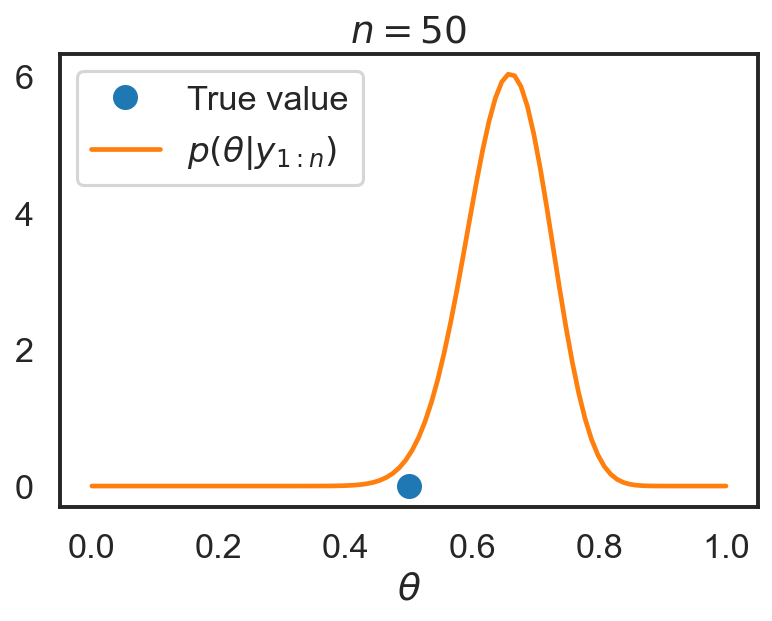

In [2]:
# Take a fake coin which is a little bit biased - Presumably unknown to us
theta_true = 0.5
# Here is the underlying random variable from which we will sample
Y = st.bernoulli(theta_true)
# Sample from it a number of times to generate our y = (y1, ..., xn)
n = 50
y = Y.rvs(size=n)
# Now we are ready to calculate the posterior which the Beta we have above
alpha = 1.0 + y.sum()
beta = 1.0 + n - y.sum()
Theta_post = st.beta(alpha, beta)
# Now we can plot the posterior PDF for theta
fig, ax = plt.subplots(dpi=150)
thetas = np.linspace(0, 1, 100)
ax.plot([theta_true], [0.0], 'o', markeredgewidth=2, markersize=10, label='True value')
ax.plot(thetas, Theta_post.pdf(thetas), label=r'$p(\theta|y_{1:n})$')
ax.set_xlabel(r'$\theta$')
ax.set_title('$n={0:d}$'.format(n))
plt.legend(loc='best')

Now that we have fitted the model, let's draw many replicated data $y^{\text{rep}}$ from the posterior predictive and compare them to the original dataset.

In [3]:
# Draw replicated data
n_rep = 9
y_rep = np.ndarray((n_rep, n))
for i in range(n_rep):
    theta_post_sample = Theta_post.rvs()
    y_rep[i, :] = st.bernoulli(theta_post_sample).rvs(size=n)

We can visualize the data as images.
The first row of pixels is are the observed data.

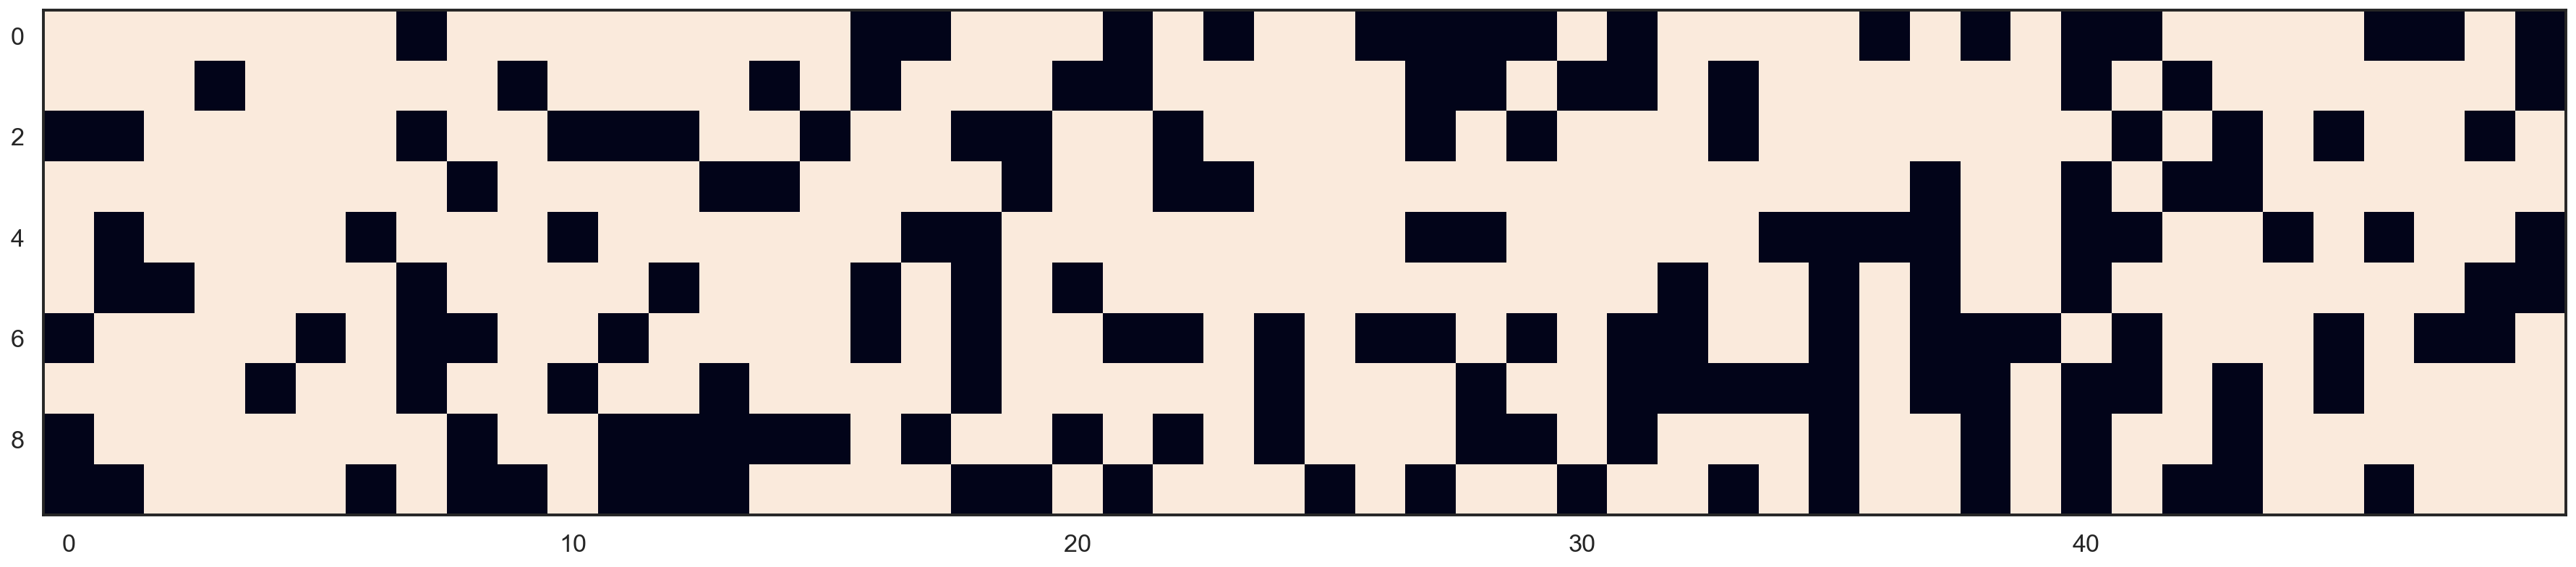

In [4]:
fig, ax = plt.subplots(figsize=(30, 10), dpi=150)
ax.imshow(np.vstack([y, y_rep]));

This visual inspection does not reveal anything strange.
Let's now repeat this excersize with a dataset that is completely artificial and does not match the model.
This a dataset that we are making by hand trying to emulate a coin toss with probability of heads equal to $0.8$:

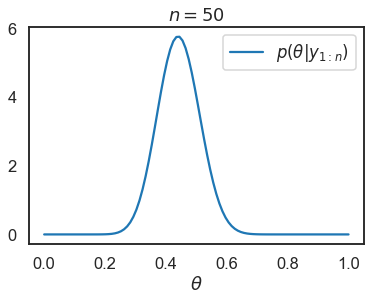

In [5]:
y_2 = np.array([0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0])
alpha_2 = 1.0 + y_2.sum()
beta_2 = 1.0 + n - y_2.sum()
Theta_2_post = st.beta(alpha_2, beta_2)
# Now we can plot the posterior PDF for theta
fig, ax = plt.subplots()
thetas = np.linspace(0, 1, 100)
ax.plot(thetas, Theta_2_post.pdf(thetas), label=r'$p(\theta|y_{1:n})$')
ax.set_xlabel(r'$\theta$')
ax.set_title('$n={0:d}$'.format(n))
plt.legend(loc='best')

There is no true value for $\theta$ here as I actually picked the data by hand.
Let's see if the visual comparison to replicated data reveals that the data did not really come from a fair coin.

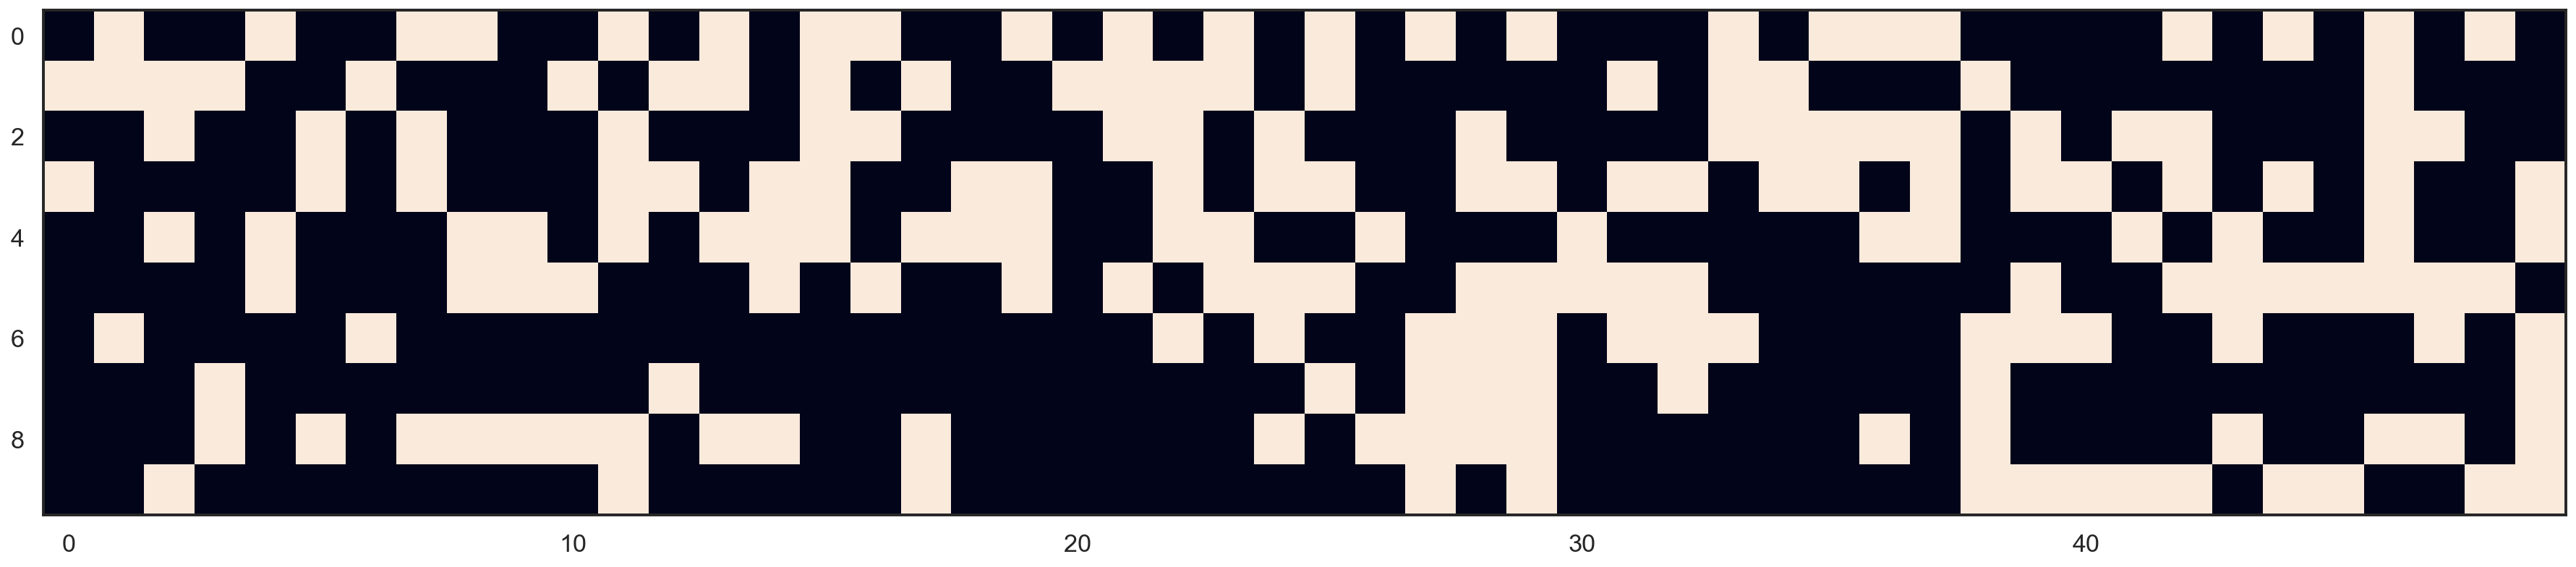

In [6]:
# Draw replicated data
n_rep = 9
y_2_rep = np.ndarray((n_rep, n))
for i in range(n_rep):
    theta_2_post_sample = Theta_2_post.rvs()
    y_2_rep[i, :] = st.bernoulli(theta_2_post_sample).rvs(size=n)
fig, ax = plt.subplots(figsize=(30, 10), dpi=150)
ax.imshow(np.vstack([y_2, y_2_rep]));

If you pay close attention you will notice that the data I picked by hand has more transitions from heads to tails than the replicated data.
In other words, the replicated data seem to have longer consecutive series of either heads or tails.
How can we see this more clearly?

### Test quantities and visual inspections

We use *test quantities* to characterize the discrepancy between the model and the data.
In particular, test quantities help us zoom into the characteristsics of the data that are of particular interest to us.
Mathematically, a test quantity is a scalar function of the data and the model parameters $T(y_{1:n},\theta)$.
There are some general recipies for creating test quantities for regression and classification.
However, in general, you must use common sense in selecting them.
What are the important characteristics of the data that your model should be capturing.
We will be seeing specific examples below.

Now, assume that you have selected one, or more, test quantities.
What do you do with them?
Well, the easiest thing to do is a visual comparison of the histogram of the test quantity over replicated data, i.e., of
$p(T(y^{\text{rep}}_{1:n},\theta) | y_{1:n})$, and compare it to the observe value $T(y_{1:n},\theta)$.
In these plots you are trying to see how likely or unlikely is observed test quantity according to your model.
We will be visualizing them next for the coin toss example.

### Test quantities and Bayesian $p$-values

Antother thing that you can do to check your model is to evaluate the probability that the replicated data give you a test quantity that is more extreme than the observed value.
This probability is known as the posterior (or Bayesian) $p$-value and it is defined by:
$$
p_B = \mathbb{P}(T(y^{\text{rep}}_{1:n},\theta) > T(y_{1:n},\theta) | y_{1:n}) = \int 1_{[T(y_{1:n},\theta),\infty]}(T(y^{\text{rep}}_{1:n})) p(y^{\text{rep}}_{1:n}, \theta|y_{1:n}) dy^{\text{rep}}_{1:n}d\theta.
$$
Of course, you can just estimate the Bayesian $p$-value using Monte Carlo sampling from the joint posterior of $y^{\text{rep}}_{1:n}$ and $\theta$ conditioned on the data $y_{1:n}$.

How should I interpret the Bayesian $p$-values?
**It is not the probability that your model is correct.**
We will derive this probability in the Bayesian model selection lecture.
The Bayesian $p$-value is the probability that replications of the experiment will yield test quantitys that exceed the observed value under the assumption that your model is correct.
So, here is a nice way to interpret them:
+ A Bayesian $p$-value close to $0$ or $1$ indicates that the observed test quantity is unlikely under the assumption that your model is correct. So your model does not capture this aspect of the data. You probably need expand/modify your model somehow.

##### Example: Inferring the Probability of a Coin Toss - Selecting and Evaluating Test Quantities

What are some good test quantities that we can pick for this example.
An obvious one is the number of heads.
This is only a function of the data.
It is:
$$
T_{h}(y_{1:n}) = \sum_{i=1}^ny_i.
$$
Let's implement this as a Python function of the data:

In [7]:
def T_h(y):
    """
    This is an implementation of a 
    """
    return y.sum()

Remember, that we have run this example with two datasets: one that was generated from the correct model and one that was generated by hand.
We will see the results that we get from both.
For the first dataset (the one generated by the model) we get:

The observed test quantity is 33
The Bayesian p_value is 0.4220


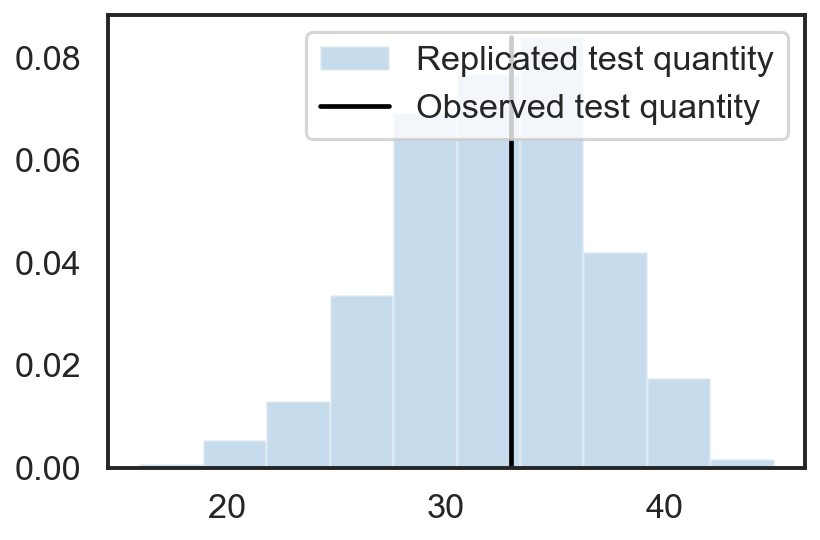

In [8]:
# The observed test quantity
T_h_obs = T_h(y)
print('The observed test quantity is {0:d}'.format(T_h_obs))
# Draw replicated data
n_rep = 1000
y_rep = np.ndarray((n_rep, n))
for i in range(n_rep):
    theta_post_sample = Theta_post.rvs()
    y_rep[i, :] = st.bernoulli(theta_post_sample).rvs(size=n)
# Evaluate the test quantity
T_h_rep = np.ndarray(y_rep.shape[0])
for i in range(y_rep.shape[0]):
    T_h_rep[i] = T_h(y_rep[i, :])
# Estimate the Bayesian p-value
p_val = np.sum(np.ones((n_rep,))[T_h_rep > T_h_obs]) / n_rep
print('The Bayesian p_value is {0:1.4f}'.format(p_val))
# Do the plot
fig, ax = plt.subplots(dpi=150)
tmp = ax.hist(T_h_rep, density=True, alpha=0.25, label='Replicated test quantity')[0]
ax.plot(T_h_obs * np.ones((50,)), np.linspace(0, tmp.max(), 50), 'k', label='Observed test quantity')
plt.legend(loc='best');

Now, let's look also at the other dataset (the one we picked by hand):

The observed test quantity is 22
The Bayesian p_value is 0.4540


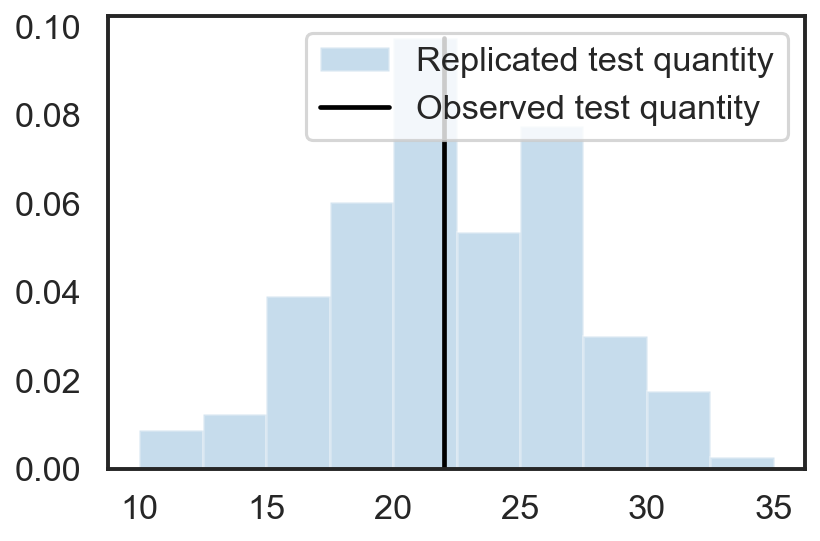

In [9]:
# The observed test quantity
T_h_2_obs = T_h(y_2)
print('The observed test quantity is {0:d}'.format(T_h_2_obs))
# Draw replicated data
n_rep = 1000
y_2_rep = np.ndarray((n_rep, n))
for i in range(n_rep):
    theta_2_post_sample = Theta_2_post.rvs()
    y_2_rep[i, :] = st.bernoulli(theta_2_post_sample).rvs(size=n)
# Evaluate the test quantity
T_h_2_rep = np.ndarray(y_2_rep.shape[0])
for i in range(y_rep.shape[0]):
    T_h_2_rep[i] = T_h(y_2_rep[i, :])
# Estimate the Bayesian p-value
p_val_2 = np.sum(np.ones((n_rep,))[T_h_2_rep > T_h_2_obs]) / n_rep
print('The Bayesian p_value is {0:1.4f}'.format(p_val_2))
# Do the plot
fig, ax = plt.subplots(dpi=150)
tmp = ax.hist(T_h_2_rep, density=True, alpha=0.25, label='Replicated test quantity')[0]
ax.plot(T_h_2_obs * np.ones((50,)), np.linspace(0, tmp.max(), 50), 'k', label='Observed test quantity')
plt.legend(loc='best');

It looks about the same. This just means that I was able to replicate this particular test quantity when I picked values by hand.
Can we find a better statistic?
Remember our observation when we plotted the replicated data vs the true data for the second case.
We observed that my hand-picked data included more transitions from heads to tails.
Let's build a statistic that captures that.
We are going to take this:
$$
T_s(y) = \text{\# number of switches from 0 and 1 in the sequence}\;y.
$$
This is not easy to write in an analytical form, but we can program it:

In [10]:
def T_s(y):
    s = 0
    for i in range(1, y.shape[0]):
        if y[i] != y[i-1]:
            s += 1
    return s

Let's look first at the original dataset:

The observed test quantity is 21
The Bayesian p_value is 0.5460


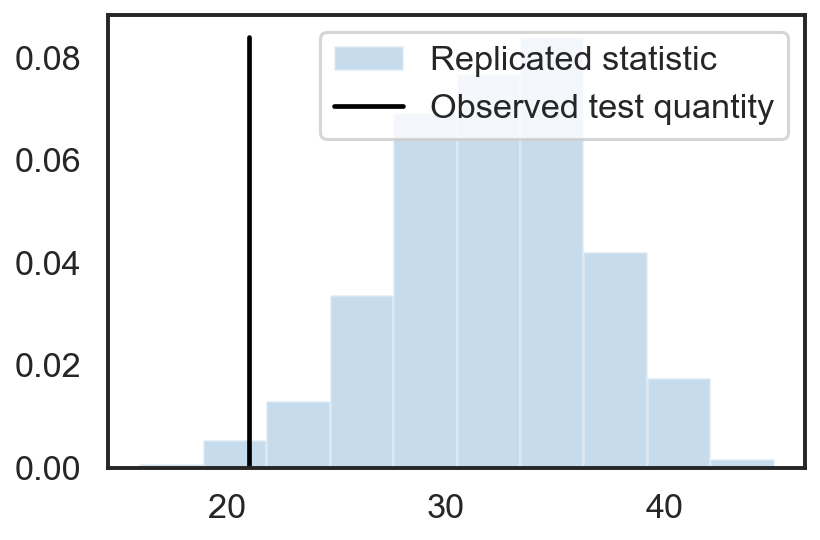

In [11]:
# The observed test quantity
T_s_obs = T_s(y)
print('The observed test quantity is {0:d}'.format(T_s_obs))
# Draw replicated data
n_rep = 1000
y_rep = np.ndarray((n_rep, n))
for i in range(n_rep):
    theta_post_sample = Theta_post.rvs()
    y_rep[i, :] = st.bernoulli(theta_post_sample).rvs(size=n)
# Evaluate the test quantity
T_s_rep = np.ndarray(y_rep.shape[0])
for i in range(y_rep.shape[0]):
    T_s_rep[i] = T_s(y_rep[i, :])
# Estimate the Bayesian p-value
p_val = np.sum(np.ones((n_rep,))[T_s_rep > T_s_obs]) / n_rep
print('The Bayesian p_value is {0:1.4f}'.format(p_val))
# Do the plot
fig, ax = plt.subplots(dpi=150)
tmp = ax.hist(T_h_rep, density=True, alpha=0.25, label='Replicated statistic')[0]
ax.plot(T_s_obs * np.ones((50,)), np.linspace(0, tmp.max(), 50), 'k', label='Observed test quantity')
plt.legend(loc='best');

This looks ok. 

Let's now look at the one I picked by hand:

The observed test quantity is 36
The Bayesian p_value is 0.0000


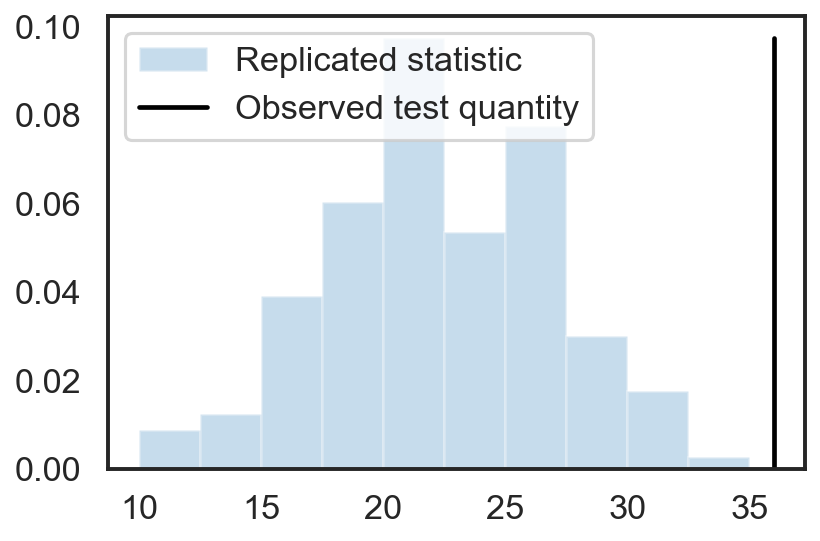

In [12]:
# The observed test quantity
T_s_2_obs = T_s(y_2)
print('The observed test quantity is {0:d}'.format(T_s_2_obs))
# Draw replicated data
n_rep = 1000
y_2_rep = np.ndarray((n_rep, n))
for i in range(n_rep):
    theta_2_post_sample = Theta_2_post.rvs()
    y_2_rep[i, :] = st.bernoulli(theta_2_post_sample).rvs(size=n)
# Evaluate the test quantity
T_s_2_rep = np.ndarray(y_2_rep.shape[0])
for i in range(y_rep.shape[0]):
    T_s_2_rep[i] = T_s(y_2_rep[i, :])
# Estimate the Bayesian p-value
p_val_2 = np.sum(np.ones((n_rep,))[T_s_2_rep > T_s_2_obs]) / n_rep
print('The Bayesian p_value is {0:1.4f}'.format(p_val_2))
# Do the plot
fig, ax = plt.subplots(dpi=150)
tmp = ax.hist(T_h_2_rep, density=True, alpha=0.25, label='Replicated statistic')[0]
ax.plot(T_s_2_obs * np.ones((50,)), np.linspace(0, tmp.max(), 50), 'k', label='Observed test quantity')
plt.legend(loc='best');

The data are highly unlikely under the assumptions of this model.

## Example: Measuring the Acceleration of Gravity

Assume that we are performing an experiment $y_i$ that measures the acceleration of gravity and that we know that the measurement variance is $\sigma = 0.1$.
So, we have:
$$
y_i | g, \sigma \sim N(g, \sigma^2).
$$
So, the model says that the measured acceleration of gravity is around the true one with some Gaussian noise.
Assume that it is adequately captured by:
$$
g | g_0, s_0 \sim N(g_0, s_0^2),
$$
with known $g_0 = 10$, $s_0 = 0.4$.
We saw in lecture 6 that our state of knowledge about the paramter $g$ is captured by:
$$
g|y_{1:n}, \sigma, g_0, s_0 \sim N\left(\frac{1}{\frac{n}{\sigma^2} + \frac{1}{s_0^2}}\left(\frac{g_0}{s_0^2} + \frac{\sum_{n=1}^Ny_n}{\sigma^2}\right),
\left(\frac{1}{s_0^2} + \frac{N}{\sigma^2}\right)^{-1}
\right).
$$
Now, let's put this model to the test using data that have different measurement noise than the one that our model assumes.
In particular, let's assume that our measurement device rounds numbers to the first digit and that it is capped, for some reason, at $10.1 m/s^2$.

Text(0, 0.5, '$y_i$')

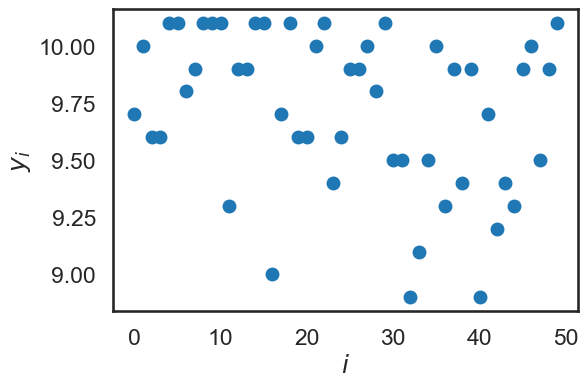

In [13]:
# Get the true acceleration of gravity from scipy
import scipy.constants
np.random.seed(12345)
g_true = scipy.constants.g
# Generate some synthetic data
n = 50
# The true noise variance
sigma = 0.4
y = np.round(g_true + sigma * np.random.randn(n), 1)
y[y > 10.1] = 10.1
fig, ax = plt.subplots(dpi=100)
ax.plot(y, 'o', label='Data')
ax.set_xlabel('$i$')
ax.set_ylabel('$y_i$')

Let's now visualize the posterior that we get with our model.

In [14]:
# Our prior state of knowledge
g0 = 9.8
s0 = 0.2
G_prior = st.norm(g0, s0)
# We shoed that the posterior for g conditioned on data is a Gaussian with mean
gn = 1.0 / (n / sigma ** 2 + 1.0 / s0 ** 2) * (g0 / s0 ** 2 + y.sum() / sigma ** 2)
# And standard deviation
sigman = np.sqrt(1.0 / (1.0 / s0 ** 2 + n / sigma ** 2))
print('The posterior of g is N({0:1.2f}, ({1:1.2f})^2)'.format(gn, sigman))

The posterior of g is N(9.73, (0.05)^2)


And here is a visualization of our posterior:

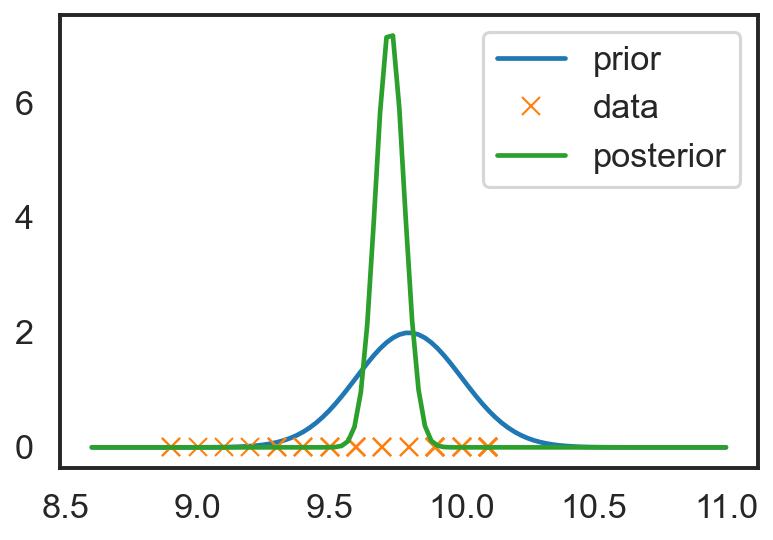

In [15]:
# Let's draw this
G_post = st.norm(gn, sigman)
fig, ax = plt.subplots(dpi=150)
ggs = np.linspace(g0 - 6.0 * s0, g0 + 6.0 * s0, 100)
ax.plot(ggs, G_prior.pdf(ggs), label='prior')
ax.plot(y, np.zeros(y.shape), 'x', label='data')
ax.plot(ggs, G_post.pdf(ggs), label='posterior')
plt.legend(loc='best');

Let's visualize the replicated data versus the true data and see if we can spot a problem.

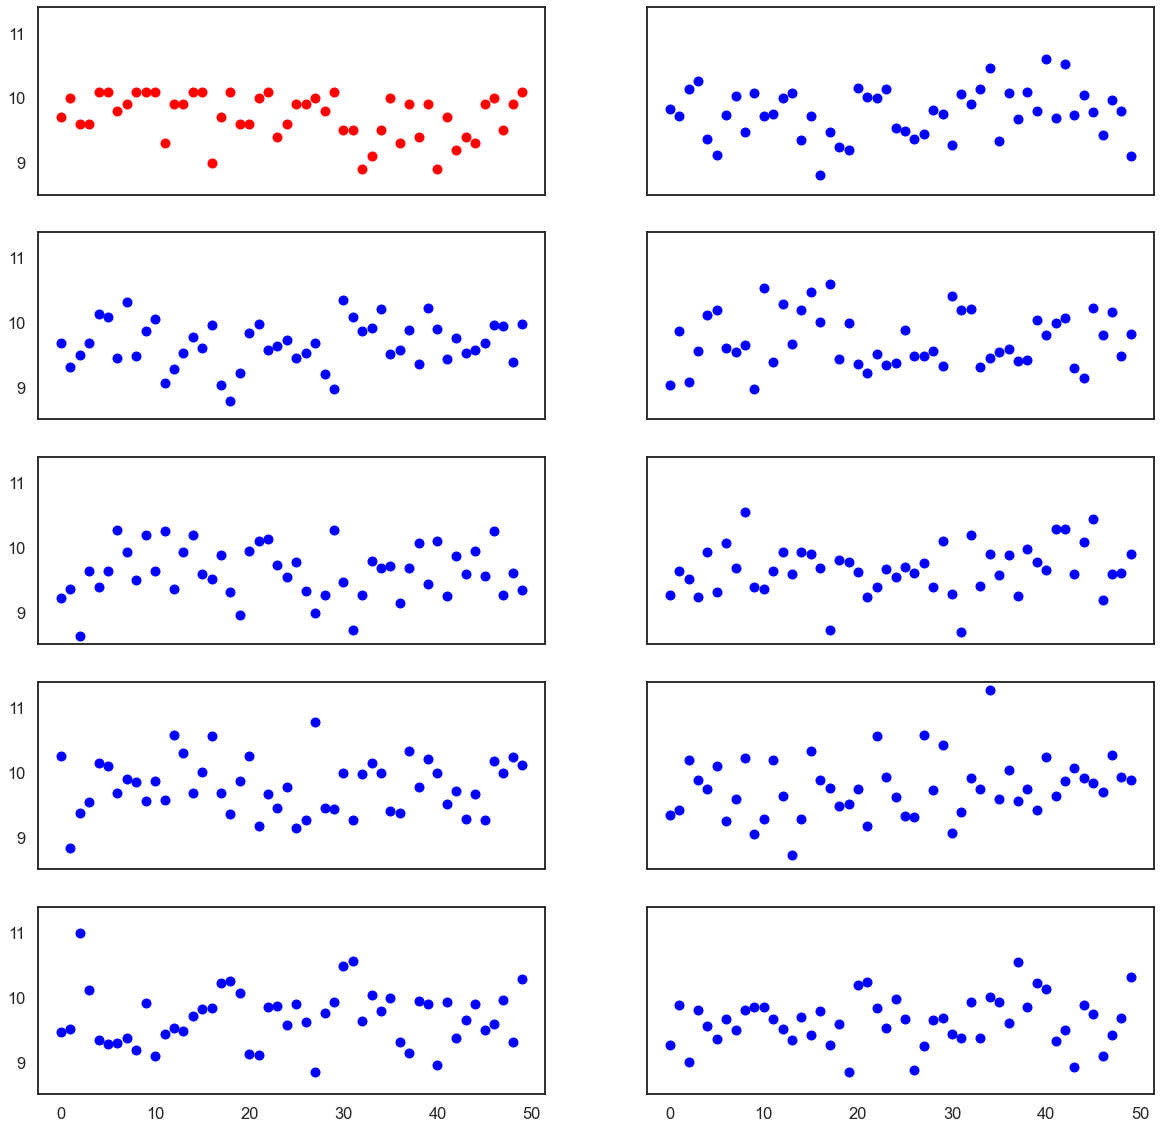

In [16]:
n_rep = 9
y_rep = np.ndarray((n_rep, n))
for i in range(n_rep):
    g_post_sample = G_post.rvs()
    y_rep[i, :] = g_post_sample + sigma * np.random.randn(n)
fig, ax = plt.subplots(5, 2, sharex='all', sharey='all', figsize=(20, 20))
ax[0, 0].plot(np.arange(n), y, 'ro');
for i in range(1, n_rep + 1):
    ax[int(i / 2), i % 2].plot(np.arange(n), y_rep[i-1], 'bo')

So, here you can clearly see the difference between the replicated data and the observations.
Is there a good test quantity to summarize this difference?
Let's look at this:
$$
T(y) = \text{\# of observations greater than 10.2}\;m/s^2.
$$
Here is how we can program it:

In [17]:
def T_g_1(y):
    return int(np.ones(y.shape)[y > 10.2].sum())

And let's try it out:

The observed test quantity is 0
The Bayesian p_value is 0.9950


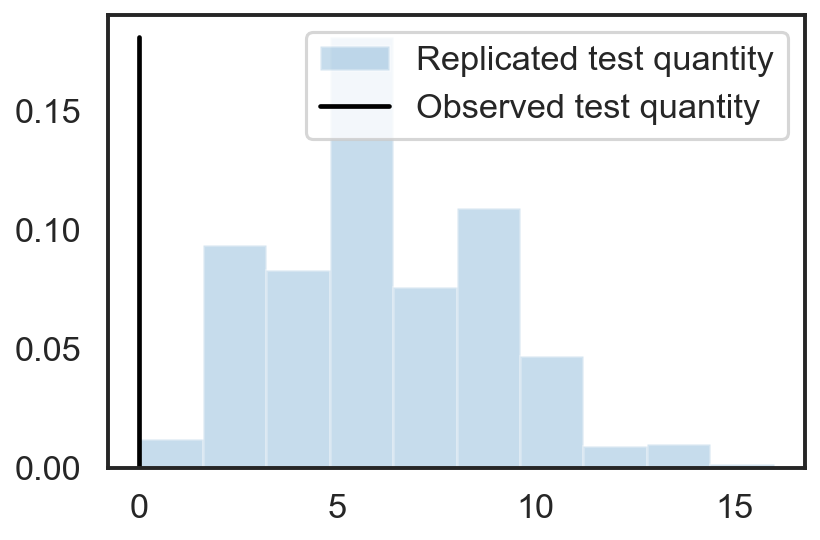

In [18]:
# The observed test quantity
T_g_obs = T_g_1(y)
print('The observed test quantity is {0:d}'.format(T_g_obs))
# Draw replicated data
n_rep = 3000
y_rep = np.ndarray((n_rep, n))
for i in range(n_rep):
    g_post_sample = G_post.rvs()
    y_rep[i, :] = g_post_sample + sigma * np.random.randn(n)
# Evaluate the test quantity
T_g_rep = np.ndarray(y_rep.shape[0])
for i in range(y_rep.shape[0]):
    T_g_rep[i] = T_g_1(y_rep[i, :])
# Estimate the Bayesian p-value
p_val = np.sum(np.ones((n_rep,))[T_g_rep > T_g_obs]) / n_rep
print('The Bayesian p_value is {0:1.4f}'.format(p_val))
# Do the plot
fig, ax = plt.subplots(dpi=150)
tmp = ax.hist(T_g_rep, density=True, alpha=0.25, label='Replicated test quantity')[0]
ax.plot(T_g_obs * np.ones((50,)), np.linspace(0, tmp.max(), 50), 'k', label='Observed test quantity')
plt.legend(loc='best');

So, you clearly see what is wrong with the model. Too many replicated data points are expected to exceed $10\;m/s^2$ than the observed value.

## Example: Number of Earthquakes in San Andreas Fault

This is the model we built in Homework 1, Problem 6.
We repeat the description here.

The [San Andreas fault](https://en.wikipedia.org/wiki/San_Andreas_Fault) extends through California forming the boundary between the Pacific and the North American tectonic plates.
It has caused some of the major earthquakes on Earth.
We are going to focus on Southern California and we would like to assess the probability of a major earthquake, defined as an earthquake of magnitude 6.5 or greater, during the next ten years.

The first thing we are going to do is go over a [database of past earthquakes](https://scedc.caltech.edu/significant/chron-index.html) that have occured in Southern California and collect the relevant data. We are going to start at 1900 because data before that time may are unreliable.
Go over each decade and count the occurence of a major earthquake (i.e., count the number of organge and red colors in each decade).

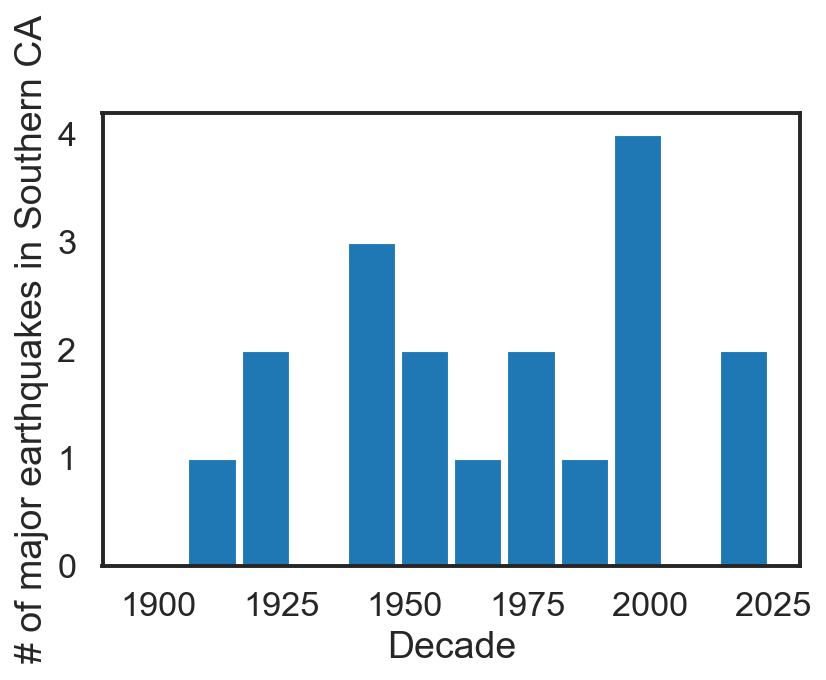

In [19]:
eq_data = np.array([
    0, # 1900-1909
    1, # 1910-1919
    2, # 1920-1929
    0, # 1930-1939
    3, # 1940-1949
    2, # 1950-1959
    1, # 1960-1969
    2, # 1970-1979
    1, # 1980-1989
    4, # 1990-1999
    0, # 2000-2009
    2 # 2010-2019 
])
fig, ax = plt.subplots(dpi=150)
ax.bar(np.linspace(1900, 2019, eq_data.shape[0]), eq_data, width=10)
ax.set_xlabel('Decade')
ax.set_ylabel('# of major earthquakes in Southern CA');

We model the number of earthquakes $y_i$ in a decade $i$ is using a Poisson distribution with unknown rate parameter $\lambda$, i.e.,
$$
y_i | \lambda \sim \operatorname{Poisson}(\lambda).
$$
The rate parameter $\lambda$ (number of major earthquakes in per ten years) is positive.
A suitable choice here is to pick a [Gamma](https://en.wikipedia.org/wiki/Gamma_distribution), see also [the scipy.stats page for the Gamma](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html).
We write:
$$
\lambda \sim \operatorname{Gamma}(\alpha, \beta),
$$
where $\alpha$ and $\beta$ are positive *hyper-parameters* that we have to set to represent our prior state of knowledge.
We pick $\alpha$ and $\beta$ by looking at the mean and the variance of the Gamma.
I expect the rate $\lambda$ to be about 2 major earthquakes per decade. So I would set for the expectation:
$$
\mathbb{E}[\lambda] = \frac{\alpha}{\beta} = 2.
$$
On the other hand, I am not so sure about it.
To model this, I would pick a large variance for $\lambda$.
I would pick a variance of $4$:
$$
\mathbb{V}[\lambda] = \frac{\alpha}{\beta^2} = 4.
$$
Solving the second equation for $\alpha$ I get:
$$
\alpha = 4\beta^2.
$$
Plugging this in the first equation I get:
$$
\frac{4\beta^2}{\beta} = 2,
$$
and solving for $\beta$ I get:
$$
\beta = 0.5.
$$
Therefore, my $\alpha$ is:
$$
\alpha = 1.
$$
Let's plot this to see if it makes sense.

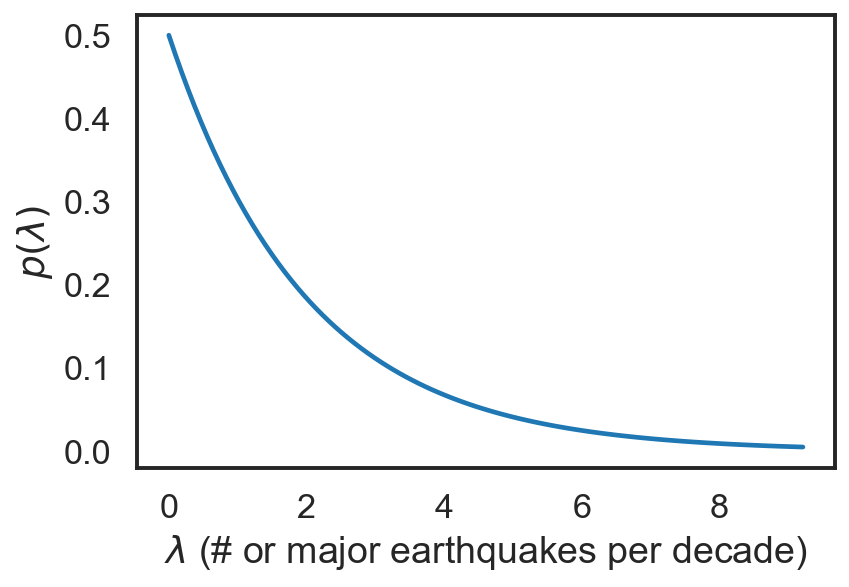

In [20]:
alpha = 1.0  # Pick them here
beta = 0.5  # Pick them here
lambda_prior = st.gamma(alpha, scale=1.0 / beta) # Make sure you understand why scale = 1 / beta
lambdas = np.linspace(0, lambda_prior.ppf(0.99), 100)
fig, ax = plt.subplots(dpi=150)
ax.plot(lambdas, lambda_prior.pdf(lambdas))
ax.set_xlabel('$\lambda$ (# or major earthquakes per decade)')
ax.set_ylabel('$p(\lambda)$');

It looks fine. 
Now, as you showed in the homework, the posterior for $\lambda$ conditioned on the data is also a Gamma:
$$
\lambda | y_{1:n} \sim \operatorname{Gamma}(\alpha+\sum_{i=1}^ny_i, \beta + n).
$$
Let's visualize it:

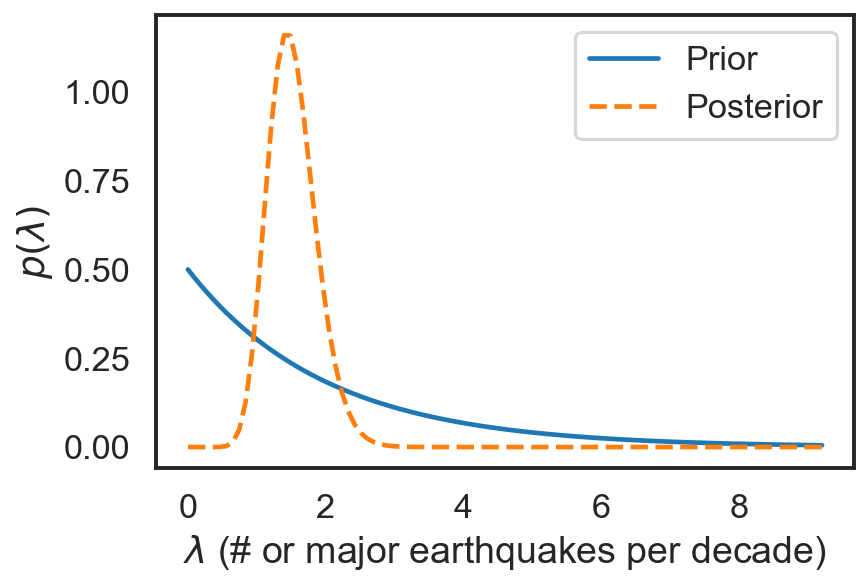

In [21]:
lambda_post = st.gamma(alpha + eq_data.sum(), scale=1.0 / (beta + eq_data.shape[0])) # Make sure you understand why scale = 1 / beta
lambdas = np.linspace(0, lambda_prior.ppf(0.99), 100)
fig, ax = plt.subplots(dpi=150)
ax.plot(lambdas, lambda_prior.pdf(lambdas), label='Prior')
ax.plot(lambdas, lambda_post.pdf(lambdas), '--', label='Posterior')
ax.set_xlabel('$\lambda$ (# or major earthquakes per decade)')
ax.set_ylabel('$p(\lambda)$')
plt.legend(loc='best');

Let's now draw replicated data from our model and compare them to the original data:

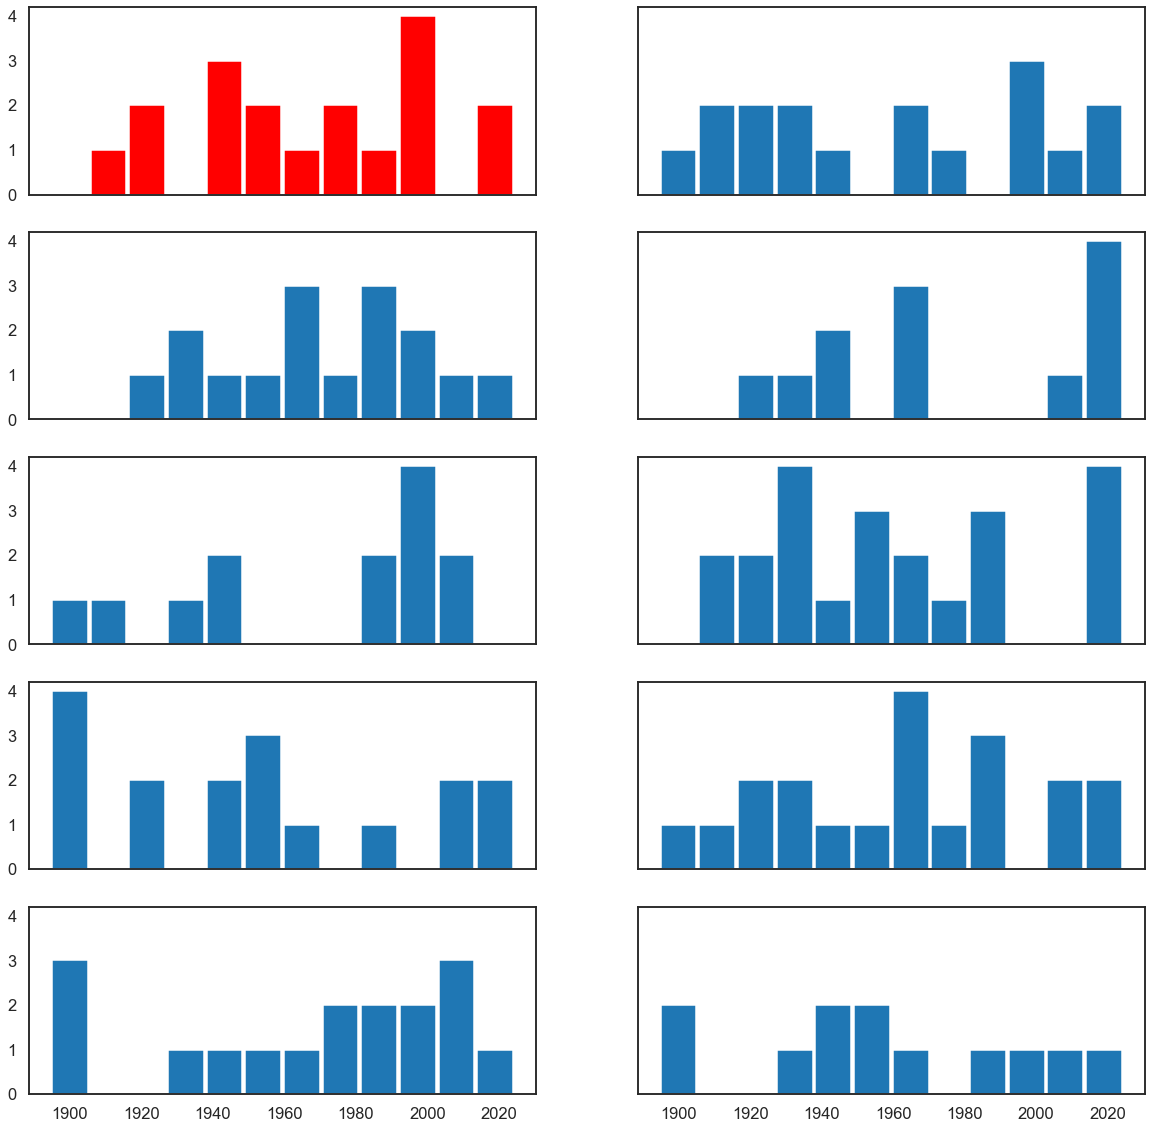

In [22]:
n_rep = 9
y_rep = np.ndarray((n_rep, eq_data.shape[0]))
for i in range(n_rep):
    lambda_post_sample = lambda_post.rvs()
    y_rep[i, :] = st.poisson(lambda_post_sample).rvs(size=eq_data.shape[0])
fig, ax = plt.subplots(5, 2, sharex='all', sharey='all', figsize=(20, 20))
ax[0, 0].bar(np.linspace(1900, 2019, eq_data.shape[0]), eq_data, width=10, color='red')
for i in range(1, n_rep + 1):
    ax[int(i / 2), i % 2].bar(np.linspace(1900, 2019, eq_data.shape[0]), y_rep[i-1], width=10)

Visually, it is not apparent that there is any problem with the model.
We don't have enough data to see any paterns anyway.
What are some good test quantities to check?
Here are some ideas:

+ Maximum number of consecutive decades with no earthquakes.
+ Maximum number of consecutive decades with earthquakes.

The observed test quantity is 1
The Bayesian p_value is 0.4136


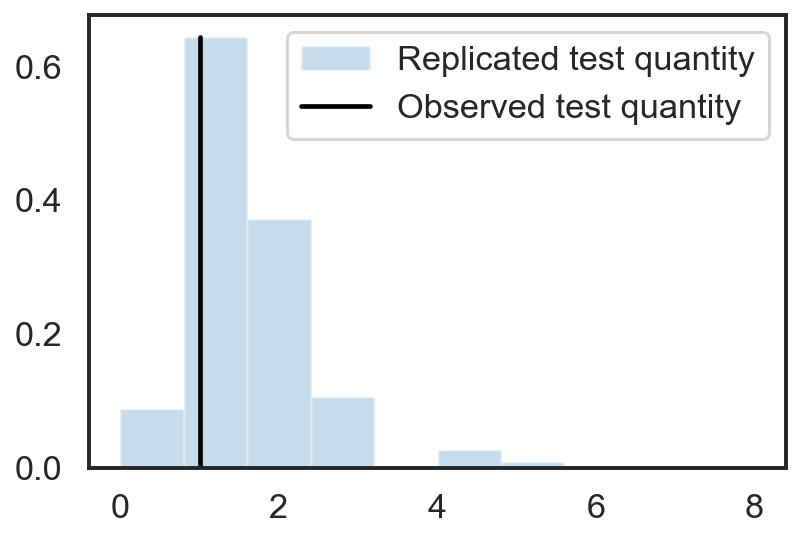

In [23]:
def T_eq_max_neq(y):
    """
    Return the maximum number of consecutive decades with no earthquakes.
    """
    count = 0
    result = 0
    for i in range(y.shape[0]):
        if y[i] != 0:
            count = 0
        else:
            count += 1
            result = max(result, count)
    return result
    
# The observed test quantity
T_eq_max_neq_obs = T_eq_max_neq(eq_data)
print('The observed test quantity is {0:d}'.format(T_eq_max_neq_obs))
# Draw replicated data
n_rep = 5000
y_rep = np.ndarray((n_rep, eq_data.shape[0]))
for i in range(n_rep):
    lambda_post_sample = lambda_post.rvs()
    y_rep[i, :] = st.poisson(lambda_post_sample).rvs(size=eq_data.shape[0])
# Evaluate the test quantity
T_eq_max_neq_rep = np.ndarray(y_rep.shape[0])
for i in range(y_rep.shape[0]):
    T_eq_max_neq_rep[i] = T_eq_max_neq(y_rep[i, :])
# Estimate the Bayesian p-value
p_val = np.sum(np.ones((n_rep,))[T_eq_max_neq_rep > T_eq_max_neq_obs]) / n_rep
print('The Bayesian p_value is {0:1.4f}'.format(p_val))
# Do the plot
fig, ax = plt.subplots(dpi=150)
tmp = ax.hist(T_eq_max_neq_rep, density=True, alpha=0.25, label='Replicated test quantity')[0]
ax.plot(T_eq_max_neq_obs * np.ones((50,)), np.linspace(0, tmp.max(), 50), 'k', label='Observed test quantity')
plt.legend(loc='best');

And it looks reasonable.
It is very possible that we have a pretty good model for this dataset.

## Questions
+ Modify the code above to check what happens for the test statisstic "maximum number of consecutive decades with at least one earthquake."